In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import fashion_mnist

In [3]:
sns.set(style="whitegrid")

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train / 255.0, axis=-1)
x_test = np.expand_dims(x_test / 255.0, axis=-1)

In [4]:
def add_noise(images, stddev=0.3):
    noisy = images + np.random.normal(loc=0.0, scale=stddev, size=images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [5]:
def get_autoencoder():
    inp = layers.Input(shape=(28, 28, 1))
    z = layers.Conv2D(64, 3, activation='relu', padding='same')(inp)
    z = layers.MaxPooling2D(2, padding='same')(z)
    z = layers.Conv2D(32, 3, activation='relu', padding='same')(z)
    encoded = layers.MaxPooling2D(2, padding='same', name="encoded")(z)

    z = layers.Conv2D(32, 3, activation='relu', padding='same')(encoded)
    z = layers.UpSampling2D()(z)
    z = layers.Conv2D(64, 3, activation='relu', padding='same')(z)
    z = layers.UpSampling2D()(z)
    out = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(z)

    auto = models.Model(inputs=inp, outputs=out)
    encoder = models.Model(inputs=inp, outputs=encoded)
    auto.compile(optimizer='adam', loss='binary_crossentropy')
    return auto, encoder

autoencoder, encoder = get_autoencoder()

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.3659 - val_loss: 0.2907
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2870 - val_loss: 0.2858
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2816 - val_loss: 0.2823
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2783 - val_loss: 0.2796
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2775 - val_loss: 0.2776
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2753 - val_loss: 0.2765
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2745 - val_loss: 0.2760
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2730 - val_loss: 0.2755
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2730 - val_loss: 0.2751
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2728 - val_loss: 0.2750
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2725 - val_loss: 0.2742
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/st

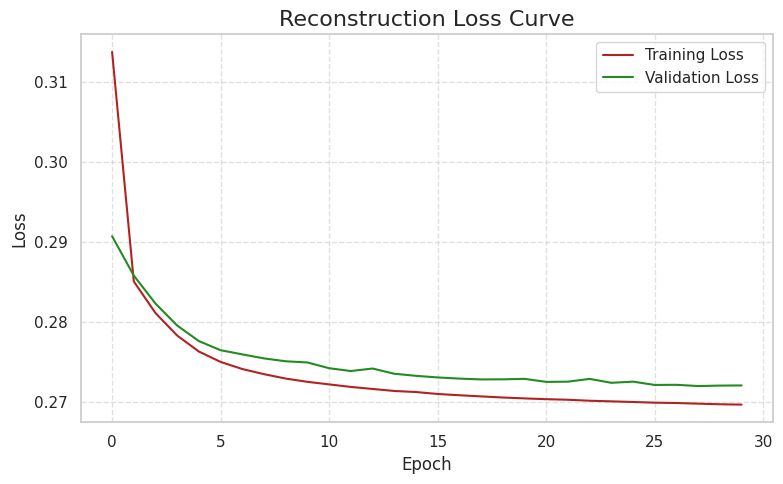

In [6]:
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(x_train_noisy, x_train,
                          validation_data=(x_test_noisy, x_test),
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          callbacks=[callback])

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='firebrick')
plt.plot(history.history['val_loss'], label='Validation Loss', color='forestgreen')
plt.title("Reconstruction Loss Curve", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


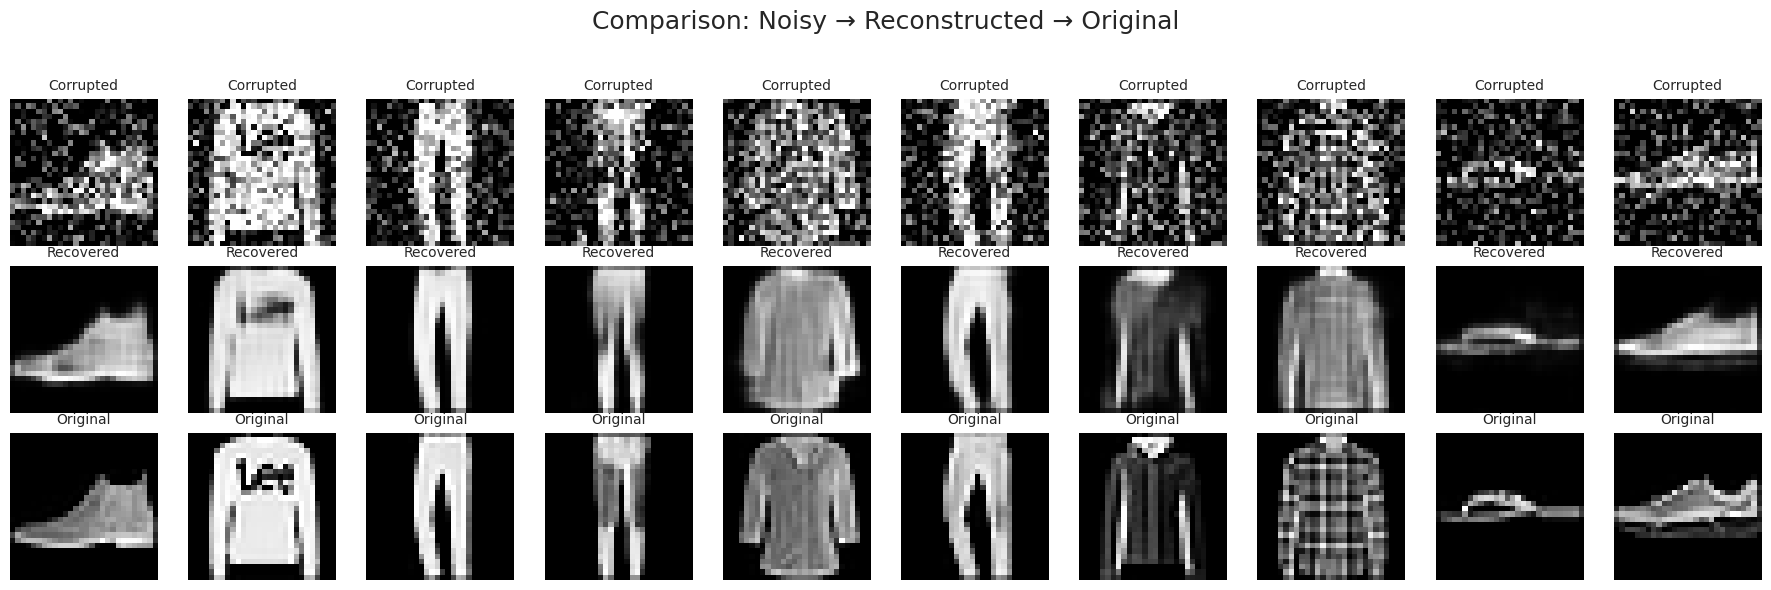

In [ ]:
samples = 10
recons = autoencoder.predict(x_test_noisy[:samples])

plt.figure(figsize=(18, 6))
for i in range(samples):
    plt.subplot(3, samples, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Corrupted", fontsize=10)
    plt.axis("off")

    # reconstructed images
    plt.subplot(3, samples, i + 1 + samples)
    plt.imshow(recons[i].sque
    
    eze(), cmap='gray')
    plt.title("Recovered", fontsize=10)
    plt.axis("off")

    # original images
    plt.subplot(3, samples, i + 1 + 2*samples)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original", fontsize=10)
    plt.axis("off")

plt.suptitle("Comparison: Noisy → Reconstructed → Original", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
latent_vecs = encoder.predict(x_test[:1000])
flat_vecs = latent_vecs.reshape(1000, -1)

# t-sne is a dimensionality reduction algorithm
tsne_model = TSNE(n_components=2, random_state=42)
tsne_2d = tsne_model.fit_transform(flat_vecs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


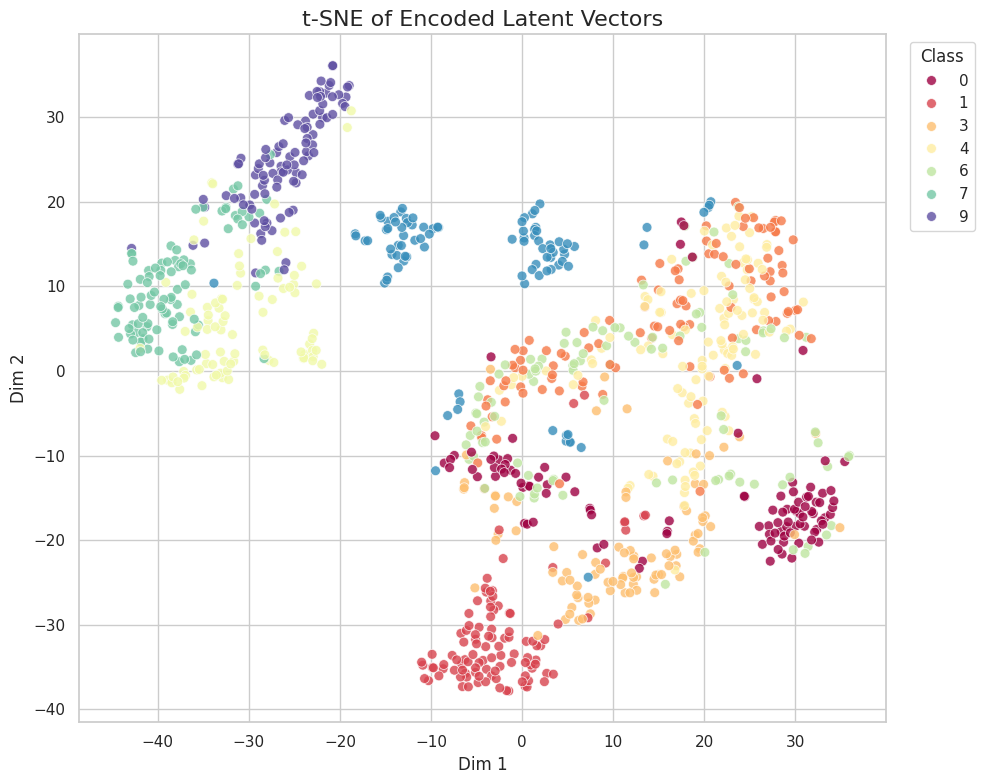

In [9]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_2d[:,0], y=tsne_2d[:,1], hue=y_test[:1000], palette='Spectral', s=50, alpha=0.8)
plt.title("t-SNE of Encoded Latent Vectors", fontsize=16)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


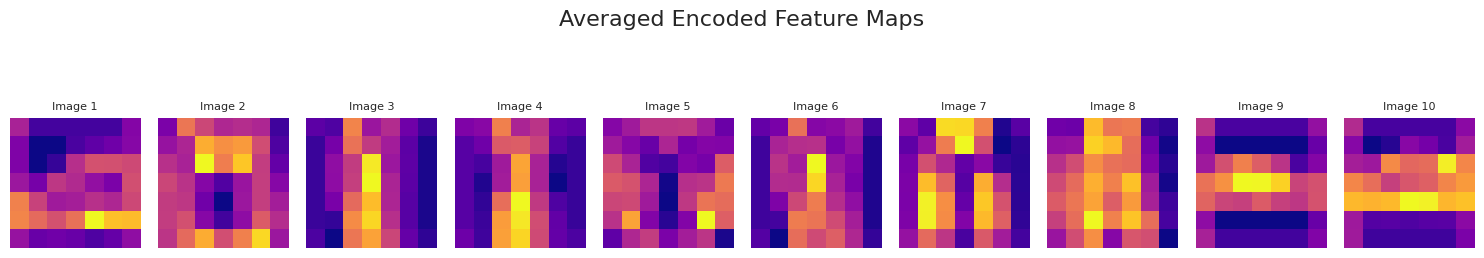

In [10]:
# feature maps visualization
n = 10
sample_maps = encoder.predict(x_test[:n])
plt.figure(figsize=(15, 3))
for i in range(n):
    feat_map = np.mean(sample_maps[i], axis=-1)
    plt.subplot(1, n, i+1)
    plt.imshow(feat_map, cmap='plasma')
    plt.title(f"Image {i+1}", fontsize=8)
    plt.axis("off")
plt.suptitle("Averaged Encoded Feature Maps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()